Note:

*   La sezione relativa alla ricerca degli iperparametri per la rete neurale è stata commentata in quanto la sua esecizione richiede tanto tempo. Nel file `NN_Hyperparameters.json` sono contenuti i risultati dell'esecuzione per il modello senza PCA, mentre per il modello addestrato con PCA sono stati salvati nel file `NN_Hyperparameters_PCA.json`,


Dataset utilizzato: [Brain Tumor](https://www.kaggle.com/datasets/jakeshbohaju/brain-tumor)


In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from google.colab import drive

drive.mount('/content/drive/')
plt.style.use('ggplot')

Mounted at /content/drive/


In [2]:
path_to_dataset = "/content/drive/MyDrive/BrainTumor/Brain Tumor.csv"

Lettura del dataset

In [3]:
dataset = pd.read_csv(path_to_dataset, index_col=0)
dataset.head()

,Class,Mean,Variance,Standard Deviation,Entropy,Skewness,Kurtosis,Contrast,Energy,ASM,Homogeneity,Dissimilarity,Correlation,Coarseness
Image,,,,,,,,,,,,,,
Image1,0,6.535339,619.587845,24.891522,0.109059,4.276477,18.900575,98.613971,0.293314,0.086033,0.530941,4.473346,0.981939,7.458341e-155
Image2,0,8.749969,805.957634,28.389393,0.266538,3.718116,14.464618,63.858816,0.475051,0.225674,0.651352,3.220072,0.988834,7.458341e-155
Image3,1,7.341095,1143.808219,33.820234,0.001467,5.061750,26.479563,81.867206,0.031917,0.001019,0.268275,5.981800,0.978014,7.458341e-155
Image4,1,5.958145,959.711985,30.979219,0.001477,5.677977,33.428845,151.229741,0.032024,0.001026,0.243851,7.700919,0.964189,7.458341e-155
Image5,0,7.315231,729.540579,27.010009,0.146761,4.283221,19.079108,174.988756,0.343849,0.118232,0.501140,6.834689,0.972789,7.458341e-155


# Preprocessing del dataset

Trasformo la variabile target in una variabile categorica

In [6]:
dataset["Class"] = dataset["Class"].astype("category")
dataset.dtypes

Class                 category
Mean                   float64
Variance               float64
Standard Deviation     float64
Entropy                float64
Skewness               float64
Kurtosis               float64
Contrast               float64
Energy                 float64
ASM                    float64
Homogeneity            float64
Dissimilarity          float64
Correlation            float64
Coarseness             float64
dtype: object

Dato che l'attributo `Coarseness` assume valori molto piccoli, applichiamo una trasformazione logaritmica.



In [9]:
import numpy as np

In [10]:
dataset['Coarseness'] = np.log10(dataset['Coarseness'])

## Suddivisione dataset

In [19]:
dataset_post_analisi = dataset[['Mean', 'Entropy', 'Skewness', 'Contrast', 'Correlation', 'Class']]

dataset_post_analisi.head()

,Mean,Entropy,Skewness,Contrast,Correlation,Class
Image,,,,,,
Image1,6.535339,0.109059,4.276477,98.613971,0.981939,0
Image2,8.749969,0.266538,3.718116,63.858816,0.988834,0
Image3,7.341095,0.001467,5.061750,81.867206,0.978014,1
Image4,5.958145,0.001477,5.677977,151.229741,0.964189,1
Image5,7.315231,0.146761,4.283221,174.988756,0.972789,0


In [20]:
y = dataset_post_analisi['Class']
X = dataset_post_analisi.drop(['Class'], axis=1)

columns_name = X.columns

Per la rete neurale e per la SVM è necessario standardizzare i dati

In [21]:
from sklearn.preprocessing import StandardScaler

Suddividiamo ora i dati in Train e Test, abbiamo scelto di utilizzare l'80% dei
dati per il training e il restante 20% per il test.

In [22]:
scaler = StandardScaler()

X_scaled = pd.DataFrame()

X_scaled[columns_name] = scaler.fit_transform(X)
X_scaled = X_scaled.set_index(X.index)

In [23]:
from sklearn.model_selection import train_test_split

In [24]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
X_train_scaled, X_test_scaled, y_train_scaled, y_test_scaled = train_test_split(X_scaled, y, test_size=0.2, stratify=y, random_state=42)

X_train.head()

,Mean,Entropy,Skewness,Contrast,Correlation
Image,,,,,
Image1439,9.691711,0.014755,4.145413,111.108108,0.980092
Image3165,2.142319,0.096746,4.610302,34.353992,0.948827
Image2317,8.229340,0.206584,3.294635,74.183124,0.978915
Image1825,5.757904,0.001252,5.415845,75.807265,0.972684
Image124,4.593552,0.001751,5.305935,92.420052,0.970507


In [25]:
X_train_scaled.head()

,Mean,Entropy,Skewness,Contrast,Correlation
Image,,,,,
Image1439,0.035413,-0.837577,0.016670,-0.153933,0.930083
Image3165,-1.282737,0.329399,0.198225,-0.854979,-0.265362
Image2317,-0.219922,1.892724,-0.315587,-0.491193,0.885115
Image1825,-0.651443,-1.029762,0.512817,-0.476359,0.646845
Image124,-0.854743,-1.022669,0.469893,-0.324623,0.563608


Per evitare di introdurre errori nell'addestramento della rete abbiamo voluto
verificare che il dataset dopo lo split fosse ancora bilanciato

In [26]:
print("Dataset:\n\t-Negative", round((y.value_counts()[0]/y.shape[0]) * 100, 2),
      "%\n\t-Positive", round((y.value_counts()[1]/y.shape[0]) * 100, 2), "%")
print("Train data:\n\t- Negative", round((y_train.value_counts()[0] / y_train.shape[0]) * 100, 2),
      "%\n\t- Positive", round((y_train.value_counts()[1] / y_train.shape[0]) * 100, 2), "%")

Dataset:
	-Negative 55.26 %
	-Positive 44.74 %
Train data:
	- Negative 55.27 %
	- Positive 44.73 %


## Analisi del dataset con PCA

In [27]:
from sklearn.decomposition import PCA

In [28]:
dataset_class = dataset['Class']
dataset_without_class = dataset.drop(['Class'], axis=1)

Standardizziamo il dataset

In [29]:
scaled_data = scaler.fit_transform(dataset_without_class)

Crea un grafico della varianza spiegata per ogni componente

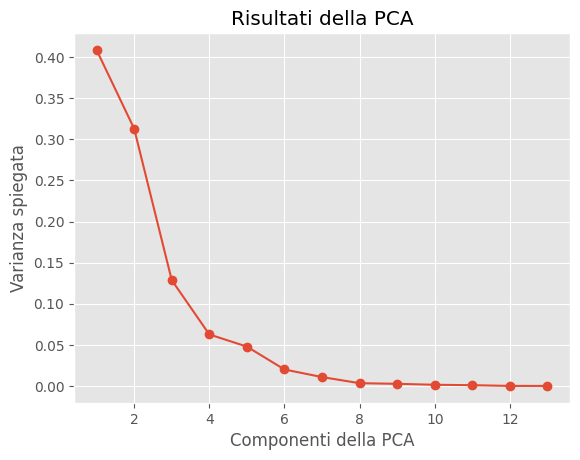

In [30]:
pca = PCA().fit(scaled_data)

plt.plot(range(1, pca.n_components_ + 1), pca.explained_variance_ratio_, marker='o')
plt.xlabel('Componenti della PCA')
plt.ylabel('Varianza spiegata')
plt.title("Risultati della PCA")
plt.show()

Applica la PCA per ridurre la dimensionalità dei dati

In [31]:
pca = PCA().fit(scaled_data)
pca_data = pca.transform(scaled_data)

print(pca.explained_variance_ratio_)
n_componenti = 3
print('Numero di componenti che spiegano la varianza: ' + str(n_componenti))
print('Varianza totale spiegata: ' + str(np.sum(pca.explained_variance_ratio_[:n_componenti])))

[4.08816773e-01 3.12991477e-01 1.28742637e-01 6.26484623e-02
 4.78447253e-02 2.00054187e-02 1.07659606e-02 3.34276945e-03
 2.55305629e-03 1.39156675e-03 8.91780975e-04 5.37250098e-06
 2.96819414e-29]
Numero di componenti che spiegano la varianza: 3
Varianza totale spiegata: 0.8505508871084848


Dal momento che la varianzia spiegata dalle prime 3 componenti allora consideriamo solo quelle.

In [32]:
dataset_pca_transformed = pd.DataFrame(pca_data[:,:n_componenti])
dataset_pca_transformed.columns = ['PCA_C1', 'PCA_C2', 'PCA_C3']
dataset_pca_transformed = dataset_pca_transformed.set_index(dataset_class.index)
dataset_pca_transformed['Class'] = dataset_class
dataset_pca_transformed.head()

,PCA_C1,PCA_C2,PCA_C3,Class
Image,,,,
Image1,-1.134947,0.116539,-0.122074,0
Image2,-4.262143,-0.049437,1.500706,0
Image3,2.481383,-1.111446,-0.957833,1
Image4,3.074085,-0.235259,-0.388747,1
Image5,-0.900927,0.311275,1.345354,0


In [33]:
import mpl_toolkits.mplot3d

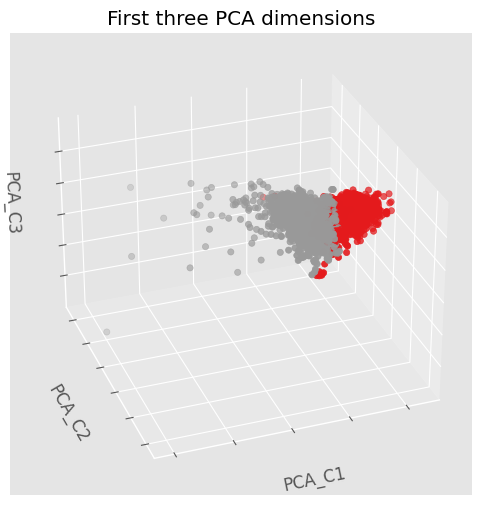

In [34]:
fig = plt.figure(1, figsize=(8, 6))
ax = fig.add_subplot(111, projection="3d", elev=-150, azim=110)

ax.scatter(
    pca_data[:, 0],
    pca_data[:, 1],
    pca_data[:, 2],
    c=dataset_class,
    cmap='Set1'
)

ax.set_title("First three PCA dimensions")
ax.set_xlabel(dataset_pca_transformed.columns[0])
ax.xaxis.set_ticklabels([])
ax.set_ylabel(dataset_pca_transformed.columns[1])
ax.yaxis.set_ticklabels([])
ax.set_zlabel(dataset_pca_transformed.columns[2])
ax.zaxis.set_ticklabels([])

plt.show()

In [35]:
X_train_pca, X_test_pca, y_train_pca, y_test_pca = train_test_split(dataset_pca_transformed[['PCA_C1', 'PCA_C2', 'PCA_C3']], dataset_pca_transformed['Class'], test_size=0.2, stratify=dataset_pca_transformed['Class'], random_state=42)

# Rete Neurale

- **Dense**: implements the operation:
```
output = activation(dot(input, kernel) + bias)
```
where activation is the element-wise activation function passed as the activation argument
- **Bainary Cross Entropy**: computes the cross-entropy loss between true labels and predicted labels.
Use this cross-entropy loss for binary (0 or 1) classification applications. The loss function requires the following inputs:
 - y_true (true label): This is either 0 or 1.
 - y_pred (predicted value): This is the model's prediction, i.e, a single floating-point value which either represents a logit, (i.e, value in [-inf, inf] when from_logits=True) or a probability (i.e, value in [0., 1.] when from_logits=False).
- **SGD**: Gradient descent (with momentum) optimizer.
- **ADAM**:

In [36]:
from keras.models import Sequential
from keras.layers import Dense

In [37]:
def create_model(units=[6, 6], activation='relu', opt='adam', metric='accuracy', input_layer_size=5):
  # Creazione del modello
  model = Sequential()

  # Aggiunta layer di input e hidden layers
  model.add(Dense(units=units[0], input_shape=(input_layer_size,), activation=activation))

  if len(units) >= 2 and units[1] != 0:
    model.add(Dense(units=units[1], activation=activation))

  # Aggiunta del layer di output
  model.add(Dense(1, activation='sigmoid'))

  # Compilazione del modello
  model.compile(loss='binary_crossentropy', optimizer=opt, metrics=[metric])

  return model

## Ricerca degli iperparametri

In [38]:
from itertools import product

In [39]:
# Iperparametri
units = [0, 5, 10, 50]
activation = ['sigmoid', 'relu', 'leaky_relu']
optimizer = ['sgd', 'adam']
batch_size = [50, 100, 300]
epochs = [100, 300]

# Creazione di tutte le possibili combinazioni
param_combinations = list(product(units, units, activation, optimizer, batch_size, epochs))

# Rimuovo le combinazioni con 0 neuroni nel primo layer
list_to_remove = []

for i, params in enumerate(param_combinations):
  if params[0] == 0:
    list_to_remove.append(params)

for to_remove in list_to_remove:
  param_combinations.remove(to_remove)

print("Total combinations:", len(param_combinations))

Total combinations: 432


In [40]:
# Preparazione del dataset per la grid search
X_cross_val_data = pd.DataFrame(data = X_train_scaled, columns = dataset_without_class.columns)
Y_cross_val_data = pd.DataFrame(data = y_train_scaled, columns = ['Class'])

Y_cross_val_data = (Y_cross_val_data.reset_index()).drop(['Image'], axis=1)
X_cross_val_data = (X_cross_val_data.reset_index()).drop(['Image'], axis=1)

In [41]:
from sklearn.model_selection import StratifiedKFold
from tqdm import tqdm

import scipy.stats as st
import numpy as np
import time
import json

In [42]:
path_for_json = "/content/drive/MyDrive/Magistrale/Machine Learning/NN_Hyperparameters"

In [43]:
def compute_statistics(performance, i):
    accuracy_score = performance[i]['results']
    time_score = performance[i]['time']
    performance[i]['interval90'] = st.t.interval(confidence=0.90, df=len(accuracy_score)-1, loc=np.mean(accuracy_score), scale=st.sem(accuracy_score))
    performance[i]['times'] = st.t.interval(confidence=0.90, df=len(time_score)-1, loc=np.mean(time_score), scale=st.sem(time_score))
    performance[i]['meanTime'] = sum(performance[i]['time']) / len(performance[i]['time'])
    performance[i]['meanAccuracy'] = sum(accuracy_score) / len(accuracy_score)

    return performance

def grid_search_NN(param_combinations, X_cross_val, Y_cross_val, input_layer_size=5, n_splits = 5,):
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True)

    # Dizionario per salvare i risultati della grid search
    performance = dict()

    # Ciclo per testare tutte le combinazioni
    for i, (u1, u2, act, opt, batch, ep) in enumerate(tqdm(param_combinations)):
        # Inizializzazione del dizionario per la combinazione corrente
        performance[i] = dict()
        performance[i]['param'] = ([u1, u2], act, opt, batch, ep)
        performance[i]['results'] = []
        performance[i]['time'] = []

        # Creazione del modello
        model = create_model(units=[u1, u2], activation=act, opt=opt, input_layer_size=input_layer_size)

        # Addestramento del modello e valutazione
        for train_idx, test_idx in skf.split(X_cross_val, Y_cross_val):
            X_val_train, X_val_test = X_cross_val.iloc[train_idx], X_cross_val.iloc[test_idx]
            y_val_train, y_val_test = Y_cross_val.iloc[train_idx], Y_cross_val.iloc[test_idx]

            start = time.time()

            model.fit(X_val_train, y_val_train, epochs=ep, batch_size=batch, verbose=0)

            end = time.time()

            # Evaluate the model on the test set
            score = model.evaluate(X_val_test, y_val_test, verbose=0)
            performance[i]['results'].append(score[1])
            performance[i]['time'].append(end - start)

        # Calcolo delle statistiche
        performance = compute_statistics(performance, i)

    # Salvataggio dei risultati su file
    with open(str(path_for_json + ".json"), "w") as outfile:
        json.dump(performance, outfile)

    return performance

def find_best_hyperparameters(performance):
    performance_interval90 = dict()
    performance_times = dict()
    performance_time = dict()
    performance_acc = dict()

    for key in list(performance.keys()):
        interval90 = performance[key]['interval90']
        interval95 = performance[key]['times']

        performance_interval90[key] = interval90[1] - interval90[0]
        performance_times[key] = interval95[1] - interval95[0]
        performance_time[key] = performance[key]['meanTime']
        performance_acc[key] = performance[key]['meanAccuracy']

    performance_interval90 = sorted(performance_interval90.items(), key=lambda x:x[1])
    performance_times = sorted(performance_times.items(), key=lambda x:x[1])
    performance_time = sorted(performance_time.items(), key=lambda x:x[1])
    performance_acc = sorted(performance_acc.items(), key=lambda x:x[1], reverse=True)

    sorted_dict = dict()

    for i, (index, _) in enumerate(performance_interval90):
        sorted_dict[index] = dict()
        sorted_dict[index]['90'] = i + 1

    for i, (index, _) in enumerate(performance_times):
        sorted_dict[index]['times_90'] = i + 1

    for i, (index, _) in enumerate(performance_time):
        sorted_dict[index]['time'] = i + 1

    for i, (index, _) in enumerate(performance_acc):
        sorted_dict[index]['acc'] = i + 1

    # Creazione del dataframe per la valutazione dei risultati
    dataframe_model = pd.DataFrame(sorted_dict)
    dataframe_model = dataframe_model.T

    # Assegno dei pesi per ogni parametro
    weights = pd.Series([1, 1, 2, 2], index=dataframe_model.columns)

    # Calcolo del punteggio totale
    dataframe_model['Total'] = (dataframe_model * weights).sum(axis=1)
    dataframe_model = dataframe_model.sort_values(by=['Total'])

    # Restituisco i parametri del modello migliore
    best_model_index = dataframe_model.index[0]
    return performance[best_model_index]['param']

Selezione degli iperparametri

In [44]:
# performance = grid_search_NN(param_combinations, X_cross_val_data, Y_cross_val_data)
# best_model = find_best_hyperparameters(performance)

best_model = ([[50, 0], 'leaky_relu', 'adam', 100, 100])

## Addestramento del modello

Creazione del modello con i migliori iperparametri

In [45]:
NN_model = create_model(units=best_model[0], activation=best_model[1], opt=best_model[2], input_layer_size=X_train.shape[1])

Visualizzazione del modello

In [46]:
import keras

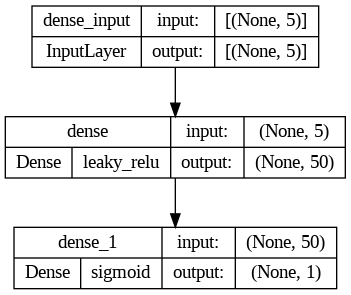

In [47]:
keras.utils.plot_model(NN_model, show_shapes=True, show_layer_activations=True, show_layer_names=True)

Addestramento del modello

In [48]:
NN_model.fit(X_train_scaled, y_train_scaled, epochs=best_model[4], batch_size=best_model[3], verbose=0)

## Valutazione del modello

Definizione di una funzione per associare un etichetta ai risultati della rete.

In [49]:
def my_predict(y_pred_proba, threshold=0.5):
    # Applicazione della soglia
    y_pred = np.where(y_pred_proba > threshold, 1, 0).flatten()

    # Restituisco le predizioni
    return y_pred

Valutazione del modello attraverso le metriche fornite da Keras

In [50]:
score = NN_model.evaluate(X_test_scaled, y_test_scaled, verbose=0)

print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.033710457384586334
Test accuracy: 0.9880478382110596


Valutazione del modello utilizzando altre metriche

In [51]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix, ConfusionMatrixDisplay

In [52]:
# Valutazione del modello utilizzando i dati di test
y_pred_proba = NN_model.predict(X_test_scaled)
y_pred = my_predict(y_pred_proba, 0.3)

# Calcolo delle prestazioni del modello
accuracy_train_test = accuracy_score(y_test_scaled, y_pred)
precision = precision_score(y_test_scaled, y_pred)
recall = recall_score(y_test_scaled, y_pred)
f1 = f1_score(y_test_scaled, y_pred)

# Stampa le prestazioni del modello
print('Accuracy:', accuracy_train_test)
print('Precision:', precision)
print('Recall:', recall)
print('F1-score:', f1)

24/24 [==============================] - 0s 2ms/step
Accuracy: 0.9893758300132802
Precision: 0.9824046920821115
Recall: 0.9940652818991098
F1-score: 0.9882005899705014


In [53]:
clf_report = classification_report(y_pred, y_test_scaled)
print(clf_report)

              precision    recall  f1-score   support

           0       0.99      1.00      0.99       412
           1       0.99      0.98      0.99       341

    accuracy                           0.99       753
   macro avg       0.99      0.99      0.99       753
weighted avg       0.99      0.99      0.99       753



Calcolo della matrice di confusione

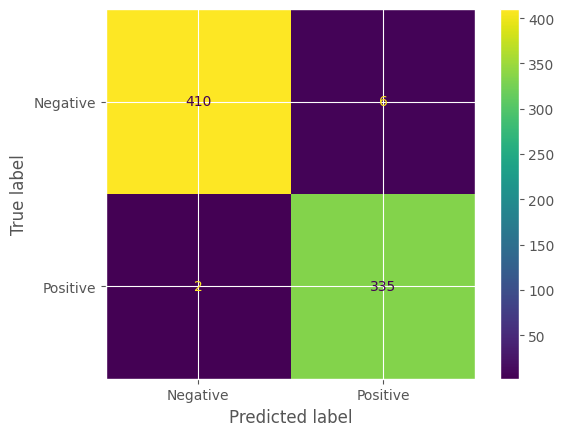

In [54]:
cm = confusion_matrix(y_test_scaled, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Negative', 'Positive'])
disp.plot()

Calcolo e disegno della curva ROC

In [55]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

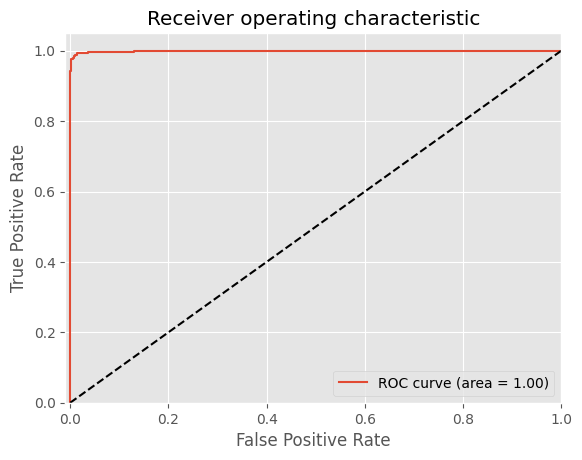

In [56]:
# Calcola la curva ROC
fpr, tpr, thresholds = roc_curve(y_test_scaled, y_pred_proba)

# Calcola l'AUC della curva ROC
roc_auc = roc_auc_score(y_test_scaled, y_pred_proba)

# Disegna la curva ROC
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([-0.01, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

### Valutazione della rete con 10-fold validation

In [57]:
n_fold = 10
folds = StratifiedKFold(n_splits=n_fold, shuffle=True)

# Inizializzazione delle liste per le prestazioni
accuracy_stratified = []
recall_stratified = []
precision_stratified = []
fscore_stratified = []

# Ciclo per la validazione incrociata
for n_fold, (train_idx, valid_idx) in enumerate(folds.split(X_scaled, y)):
  # Split train and validation set
  X_train, X_valid = X_scaled.iloc[train_idx], X_scaled.iloc[valid_idx]
  y_train, y_valid = y[train_idx], y[valid_idx]

  # Creazione del modello
  model = create_model(units=best_model[0], activation=best_model[1], opt=best_model[2], input_layer_size=X_train.shape[1])

  # Addestramento del modello
  model.fit(X_train, y_train, epochs=best_model[4], batch_size=best_model[3], verbose=0)

  # Valutazione del modello
  y_pred_proba = model.predict(X_valid)
  y_pred_valid = my_predict(y_pred_proba, 0.3)

  accuracy_stratified.append(accuracy_score(y_valid, y_pred_valid))
  precision_stratified.append(precision_score(y_valid, y_pred_valid))
  recall_stratified.append(recall_score(y_valid, y_pred_valid))
  fscore_stratified.append(f1_score(y_valid, y_pred_valid))

12/12 [==============================] - 0s 2ms/step


Calcolo dell'intervallo di confidenza

In [58]:
confidence = 0.90
# Calcolo degli intervalli di confidenza
acc_interval = st.t.interval(confidence=confidence, df=len(accuracy_stratified)-1, loc=np.mean(accuracy_stratified), scale=st.sem(accuracy_stratified))
precision_interval = st.t.interval(confidence=confidence, df=len(precision_stratified)-1, loc=np.mean(precision_stratified), scale=st.sem(precision_stratified))
recall_interval = st.t.interval(confidence=confidence, df=len(recall_stratified)-1, loc=np.mean(recall_stratified), scale=st.sem(recall_stratified))
fscore_interval = st.t.interval(confidence=confidence, df=len(fscore_stratified)-1, loc=np.mean(fscore_stratified), scale=st.sem(fscore_stratified))

print("Accuracy:", np.mean(accuracy_stratified), acc_interval)
print("Precision:", np.mean(precision_stratified), precision_interval)
print("Recall:", np.mean(recall_stratified), recall_interval)
print("F1-score:", np.mean(fscore_stratified), fscore_interval)

Accuracy: 0.9803297307974491 (0.9754524767498945, 0.9852069848450037)
Precision: 0.974763877826762 (0.9671850454701597, 0.9823427101833643)
Recall: 0.981572273879966 (0.9758428488573792, 0.9873016989025528)
F1-score: 0.9781119860622425 (0.972721232650826, 0.983502739473659)


Grafico degli intervalli di confidenza

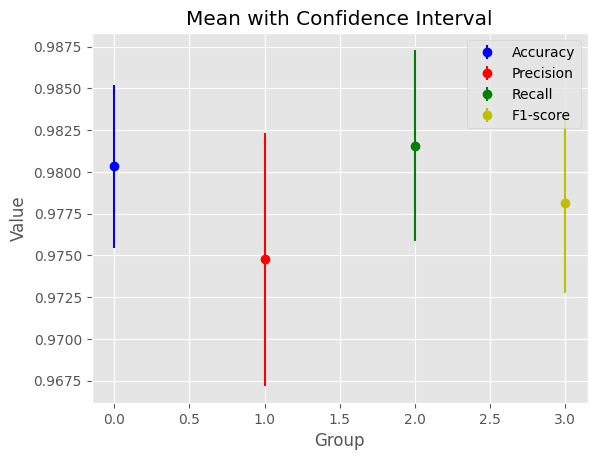

In [59]:
# Plot the mean and confidence interval
plt.errorbar(0, np.mean(acc_interval), yerr=(acc_interval[1] - acc_interval[0])/2, fmt='o', label='Accuracy', color='b')
plt.errorbar(1, np.mean(precision_interval), yerr=(precision_interval[1] - precision_interval[0])/2, fmt='o', label='Precision', color='r')
plt.errorbar(2, np.mean(recall_interval), yerr=(recall_interval[1] - recall_interval[0])/2, fmt='o', label='Recall', color='g')
plt.errorbar(3, np.mean(fscore_interval), yerr=(fscore_interval[1] - fscore_interval[0])/2, fmt='o', label='F1-score', color='y')

# Add labels and title
plt.xlabel('Group')
plt.ylabel('Value')
plt.title('Mean with Confidence Interval')

# Show the plot
plt.legend()
plt.show()

## Rete neurale con PCA

In [60]:
path_for_json = "/content/drive/MyDrive/Magistrale/Machine Learning/NN_Hyperparameters_PCA"

In [61]:
X_cross_PCA_data = pd.DataFrame(data = X_train_pca, columns = ['PCA_C1', 'PCA_C2', 'PCA_C3'])
Y_cross_PCA_data = pd.DataFrame(data = y_train_pca, columns = ['Class'])

Y_cross_PCA_data = (Y_cross_PCA_data.reset_index()).drop(['Image'], axis=1)
X_cross_PCA_data = (X_cross_PCA_data.reset_index()).drop(['Image'], axis=1)

In [62]:
# performance = grid_search_NN(param_combinations, X_cross_PCA_data, Y_cross_PCA_data, input_layer_size=3)
# best_model_PCA = find_best_hyperparameters(performance)

best_model_PCA = ([50, 0], 'leaky_relu', 'adam', 300, 100)

### Addestramento rete con PCA

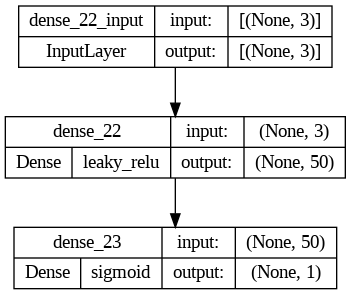

In [63]:
NN_PCA_model = create_model(units=best_model_PCA[0], activation=best_model_PCA[1], opt=best_model_PCA[2], input_layer_size=X_train_pca.shape[1])

keras.utils.plot_model(NN_PCA_model, show_shapes=True, show_layer_activations=True, show_layer_names=True)

In [64]:
NN_PCA_model.fit(X_train_pca, y_train_pca, epochs=best_model_PCA[4], batch_size=best_model_PCA[3], verbose=0)

### Valutazione del modello

In [65]:
score = NN_PCA_model.evaluate(X_test_pca, y_test_pca, verbose=0)

print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.05425922945141792
Test accuracy: 0.9840637445449829


In [66]:
# Valutazione del modello utilizzando i dati di test
y_pred_proba_PCA = NN_PCA_model.predict(X_test_pca)
y_pred_PCA = my_predict(y_pred_proba_PCA, 0.3)

# Calcolo delle prestazioni del modello
accuracy_train_test = accuracy_score(y_test_pca, y_pred_PCA)
precision = precision_score(y_test_pca, y_pred_PCA)
recall = recall_score(y_test_pca, y_pred_PCA)
f1 = f1_score(y_test_pca, y_pred_PCA)

# Stampa le prestazioni del modello
print('Accuracy:', accuracy_train_test)
print('Precision:', precision)
print('Recall:', recall)
print('F1-score:', f1)

24/24 [==============================] - 0s 1ms/step
Accuracy: 0.9800796812749004
Precision: 0.9707602339181286
Recall: 0.9851632047477745
F1-score: 0.9779086892488954


In [67]:
clf_report = classification_report(y_pred_PCA, y_test_pca)
print(clf_report)

              precision    recall  f1-score   support

           0       0.98      0.99      0.98       411
           1       0.99      0.97      0.98       342

    accuracy                           0.98       753
   macro avg       0.98      0.98      0.98       753
weighted avg       0.98      0.98      0.98       753



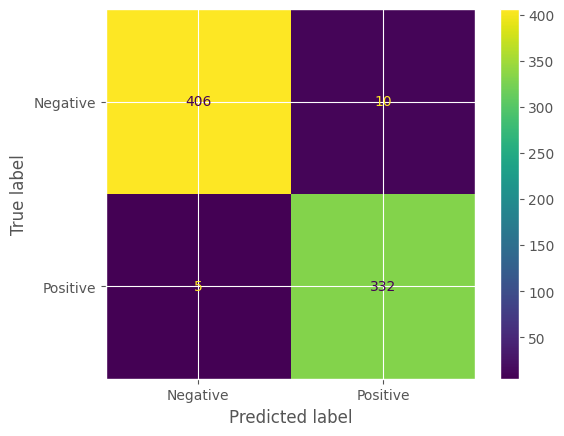

In [68]:
cm = confusion_matrix(y_test_pca, y_pred_PCA)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Negative', 'Positive'])
disp.plot()

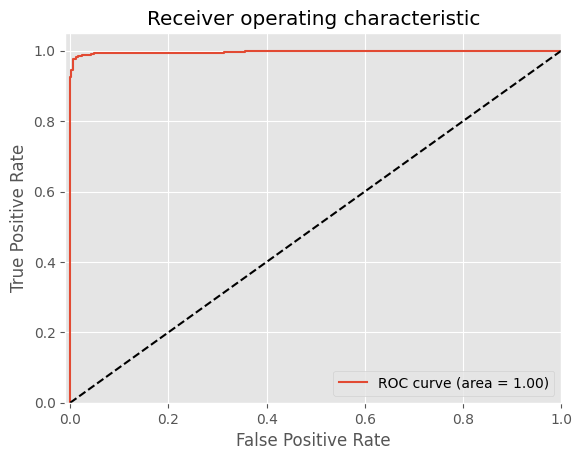

In [69]:
# Calcola la curva ROC
fpr, tpr, thresholds = roc_curve(y_test_pca, y_pred_proba_PCA)

# Calcola l'AUC della curva ROC
roc_auc = roc_auc_score(y_test_pca, y_pred_proba_PCA)

# Disegna la curva ROC
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([-0.01, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

#### K-fold validation

In [70]:
n_fold = 10
folds = StratifiedKFold(n_splits=n_fold, shuffle=True)

# Inizializzazione delle liste per le prestazioni
accuracy_stratified_pca = []
recall_stratified_pca = []
precision_stratified_pca = []
fscore_stratified_pca = []

# Ciclo per la validazione incrociata
for n_fold, (train_idx, valid_idx) in enumerate(folds.split(dataset_pca_transformed[['PCA_C1', 'PCA_C2', 'PCA_C3']], dataset_pca_transformed['Class'])):
  # Split train and validation set
  X_train, X_valid = X_scaled.iloc[train_idx], X_scaled.iloc[valid_idx]
  y_train, y_valid = y[train_idx], y[valid_idx]

  # Creazione del modello
  model = create_model(units=best_model[0], activation=best_model[1], opt=best_model[2], input_layer_size=X_train.shape[1])

  # Addestramento del modello
  model.fit(X_train, y_train, epochs=best_model[4], batch_size=best_model[3], verbose=0)

  # Valutazione del modello
  y_pred_proba = model.predict(X_valid)
  y_pred_valid = my_predict(y_pred_proba, 0.3)

  accuracy_stratified_pca.append(accuracy_score(y_valid, y_pred_valid))
  precision_stratified_pca.append(precision_score(y_valid, y_pred_valid))
  recall_stratified_pca.append(recall_score(y_valid, y_pred_valid))
  fscore_stratified_pca.append(f1_score(y_valid, y_pred_valid))

12/12 [==============================] - 0s 2ms/step


In [71]:
confidence = 0.90
# Calcolo degli intervalli di confidenza
acc_interval_pca = st.t.interval(confidence=confidence, df=len(accuracy_stratified_pca)-1, loc=np.mean(accuracy_stratified_pca), scale=st.sem(accuracy_stratified_pca))
precision_interval_pca = st.t.interval(confidence=confidence, df=len(precision_stratified_pca)-1, loc=np.mean(precision_stratified_pca), scale=st.sem(precision_stratified_pca))
recall_interval_pca = st.t.interval(confidence=confidence, df=len(recall_stratified_pca)-1, loc=np.mean(recall_stratified_pca), scale=st.sem(recall_stratified_pca))
fscore_interval_pca = st.t.interval(confidence=confidence, df=len(fscore_stratified_pca)-1, loc=np.mean(fscore_stratified_pca), scale=st.sem(fscore_stratified_pca))

print("Accuracy:", np.mean(accuracy_stratified_pca), acc_interval_pca)
print("Precision:", np.mean(precision_stratified_pca), precision_interval_pca)
print("Recall:", np.mean(recall_stratified_pca), recall_interval_pca)
print("F1-score:", np.mean(fscore_stratified_pca), fscore_interval_pca)

Accuracy: 0.9803290253400305 (0.974643778567853, 0.986014272112208)
Precision: 0.9748133957925147 (0.9656045640269663, 0.9840222275580631)
Recall: 0.9815898844745 (0.9758733904519407, 0.9873063784970594)
F1-score: 0.978133086829029 (0.9718994630078658, 0.9843667106501922)


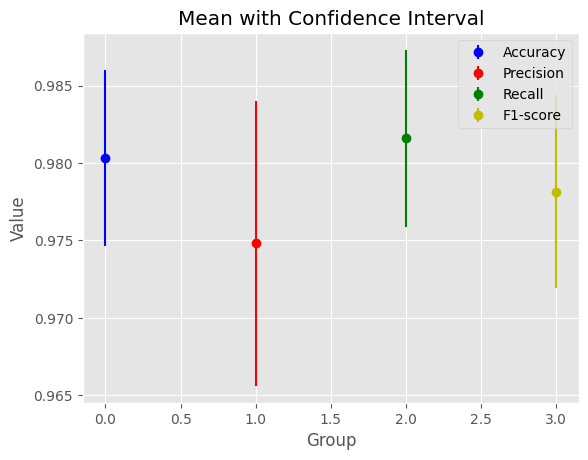

In [72]:
# Plot the mean and confidence interval
plt.errorbar(0, np.mean(acc_interval_pca), yerr=(acc_interval_pca[1] - acc_interval_pca[0])/2, fmt='o', label='Accuracy', color='b')
plt.errorbar(1, np.mean(precision_interval_pca), yerr=(precision_interval_pca[1] - precision_interval_pca[0])/2, fmt='o', label='Precision', color='r')
plt.errorbar(2, np.mean(recall_interval_pca), yerr=(recall_interval_pca[1] - recall_interval_pca[0])/2, fmt='o', label='Recall', color='g')
plt.errorbar(3, np.mean(fscore_interval_pca), yerr=(fscore_interval_pca[1] - fscore_interval_pca[0])/2, fmt='o', label='F1-score', color='y')

# Add labels and title
plt.xlabel('Group')
plt.ylabel('Value')
plt.title('Mean with Confidence Interval')

# Show the plot
plt.legend()
plt.show()

## Confronto modelli addestrati su dataset creati con e senza PCA

24/24 [==============================] - 0s 3ms/step


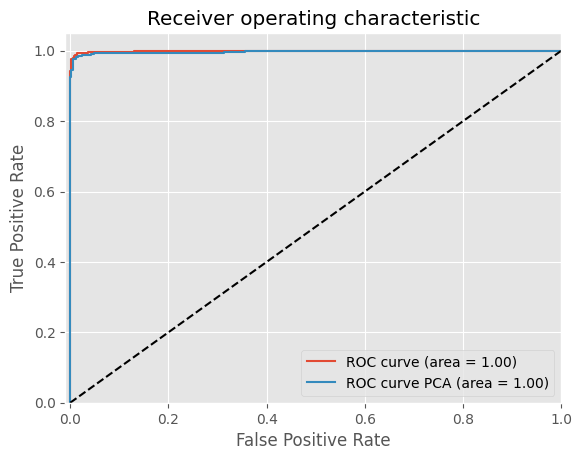

In [73]:
y_pred_proba = NN_model.predict(X_test_scaled)
y_pred_proba_PCA = NN_PCA_model.predict(X_test_pca)

# Calcola la curva ROC
fpr, tpr, thresholds = roc_curve(y_test_scaled, y_pred_proba)
fpr_PCA, tpr_PCA, thresholds_PCA = roc_curve(y_test_pca, y_pred_proba_PCA)

# Calcola l'AUC della curva ROC
roc_auc = roc_auc_score(y_test_scaled, y_pred_proba)
roc_auc_PCA = roc_auc_score(y_test_pca, y_pred_proba_PCA)

# Disegna la curva ROC
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot(fpr_PCA, tpr_PCA, label='ROC curve PCA (area = %0.2f)' % roc_auc_PCA)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([-0.01, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

Confronto intervalli di confidenza dei modelli

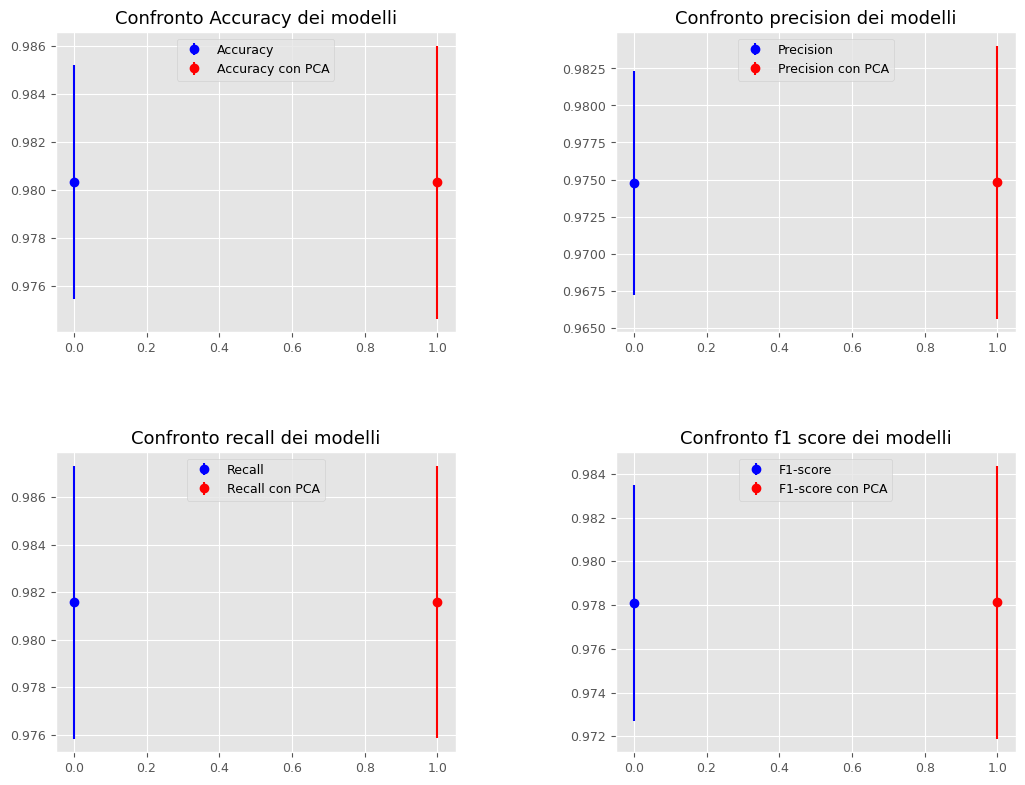

In [97]:
plt.figure(figsize=(12, 9))
plt.rc('font', size=9)
plt.subplots_adjust(left=0.1, bottom=0.1, right=0.9, top=0.9, wspace=0.4, hspace=0.4)

plt.subplot(221)
plt.errorbar(0, np.mean(acc_interval), yerr=(acc_interval[1] - acc_interval[0])/2, fmt='o', label='Accuracy', color='b')
plt.errorbar(1, np.mean(acc_interval_pca), yerr=(acc_interval_pca[1] - acc_interval_pca[0])/2, fmt='o', label='Accuracy con PCA', color='r')
plt.title('Confronto Accuracy dei modelli')
plt.legend(loc='upper center')

plt.subplot(222)
plt.errorbar(0, np.mean(precision_interval), yerr=(precision_interval[1] - precision_interval[0])/2, fmt='o', label='Precision', color='b')
plt.errorbar(1, np.mean(precision_interval_pca), yerr=(precision_interval_pca[1] - precision_interval_pca[0])/2, fmt='o', label='Precision con PCA', color='r')
plt.title('Confronto precision dei modelli')
plt.legend(loc='upper center')

plt.subplot(223)
plt.errorbar(0, np.mean(recall_interval), yerr=(recall_interval[1] - recall_interval[0])/2, fmt='o', label='Recall', color='b')
plt.errorbar(1, np.mean(recall_interval_pca), yerr=(recall_interval_pca[1] - recall_interval_pca[0])/2, fmt='o', label='Recall con PCA', color='r')
plt.title('Confronto recall dei modelli')
plt.legend(loc='upper center')

plt.subplot(224)
plt.errorbar(0, np.mean(fscore_interval), yerr=(fscore_interval[1] - fscore_interval[0])/2, fmt='o', label='F1-score', color='b')
plt.errorbar(1, np.mean(fscore_interval_pca), yerr=(fscore_interval_pca[1] - fscore_interval_pca[0])/2, fmt='o', label='F1-score con PCA', color='r')
plt.title('Confronto f1 score dei modelli')
plt.legend(loc='upper center');